# Introduction

This notebook continues our series about data visualization using the Covid19 data from the [Kaggle challenge](https://www.kaggle.com/c/covid19-global-forecasting-week-2). This notebook addresses the creation of appealing plots with interactive features. We describe three examples:

* Matplotlib
* Plotly
* Plotly + ipywidgets

If you're planning to run this notebook in your own Jupyter, please follow the indications to have the correct configuration to run `plotly` with `ipywidgets` [here](https://plotly.com/python/getting-started/#jupyter-notebook-support).

**Assumptions**
* You succesfully run the [Covid19 visualization notebook](./Covid19%20plots%20visualization.ipynb)
* You have an already running Jupyter environment
* You are familiar with Pandas
* You have heard about Matplotlib
* The covid19 files are available in the path covid19-global-forecasting-week-2

# Load the data

Load the CSV data as we did in the previous notebook.

In [14]:
import pandas as pd

data = pd.read_csv("covid19-global-forecasting-week-2/train.csv")

In [15]:
# Get data for Spain
spain = data[data['Country_Region']=='Spain']
spain

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities
13376,20901,Spain,NaN,2020-01-22,0.0,0.0
13377,20902,Spain,NaN,2020-01-23,0.0,0.0
13378,20903,Spain,NaN,2020-01-24,0.0,0.0
13379,20904,Spain,NaN,2020-01-25,0.0,0.0
13380,20905,Spain,NaN,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
13435,20960,Spain,NaN,2020-03-21,25374.0,1375.0
13436,20961,Spain,NaN,2020-03-22,28768.0,1772.0
13437,20962,Spain,NaN,2020-03-23,35136.0,2311.0
13438,20963,Spain,NaN,2020-03-24,39885.0,2808.0


In [16]:
# Sample of countries to study.
# We include China this time.
chosen = ['Spain', 'Iran', 'Singapore', 'France', 'United Kingdom', 'China']

# 1) Filter rows which country is in the list  2) group by country and date and finally sum the result
sample = data[data.Country_Region.isin(chosen)].groupby(['Date','Country_Region'], as_index=False,).sum()
sample

,Date,Country_Region,Id,ConfirmedCases,Fatalities
0,2020-01-22,China,214533,548.0,17.0
1,2020-01-22,France,112510,0.0,0.0
2,2020-01-22,Iran,13601,0.0,0.0
3,2020-01-22,Singapore,20401,0.0,0.0
4,2020-01-22,Spain,20901,0.0,0.0
...,...,...,...,...,...
379,2020-03-25,France,113140,25600.0,1333.0
380,2020-03-25,Iran,13664,27017.0,2077.0
381,2020-03-25,Singapore,20464,631.0,2.0
382,2020-03-25,Spain,20964,49515.0,3647.0


# Matplotlib

The most simple (and limited) solution to have an interactive plot using Matplotlib and Jupyter is to use the `%matplotlib notebook` line. Using this you can have an interactive plot with zoom and download image capabilities. To stop the interaction you have to click on the button.


<IPython.core.display.Javascript object>


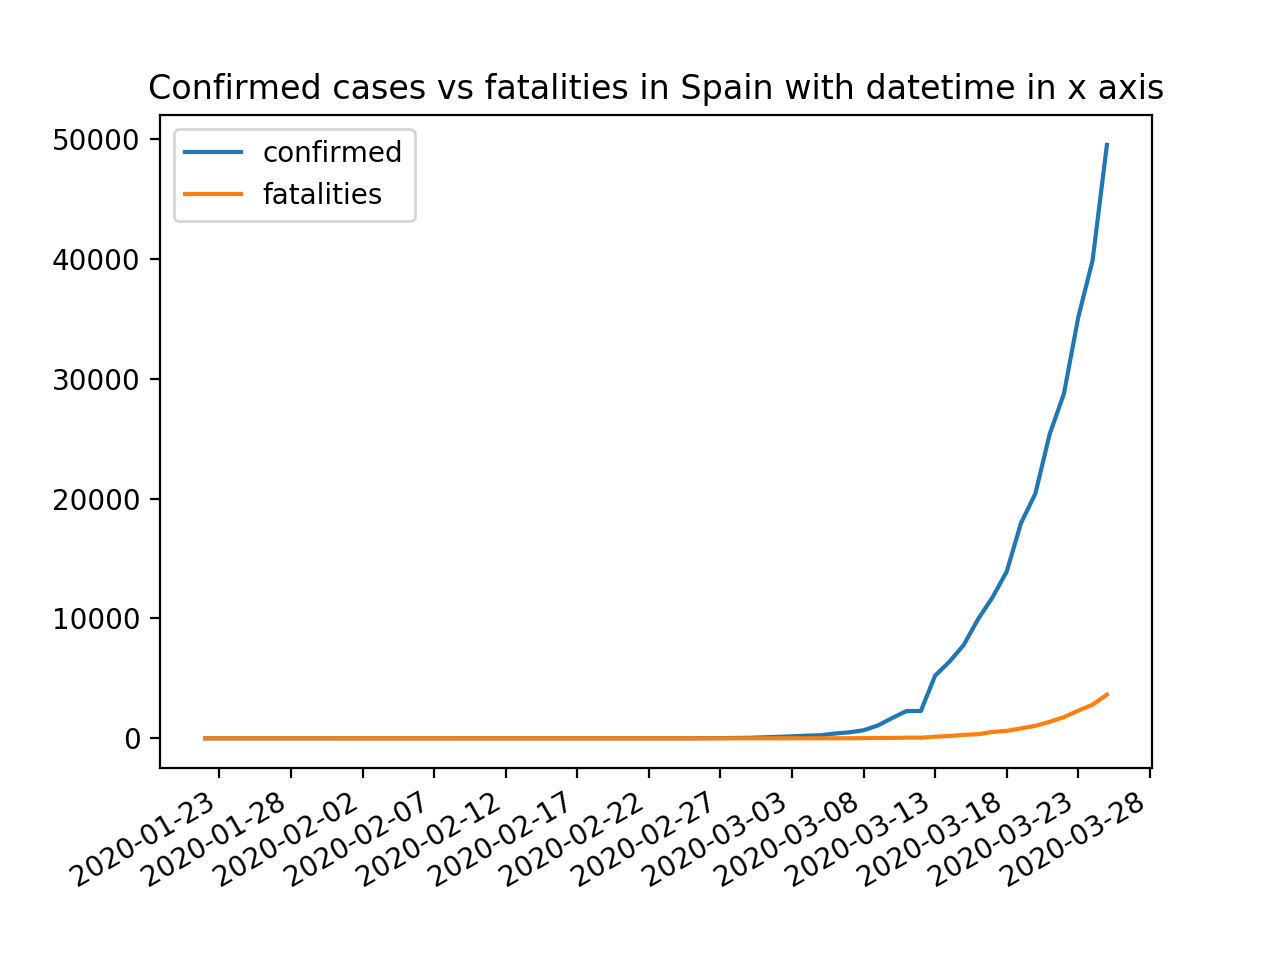

In [27]:
from matplotlib import pyplot
import matplotlib.dates as mdates

# convert date strings to datenums
dates = mdates.datestr2num(spain.Date)

# Call this directive to run an interactive plot
%matplotlib notebook
pyplot.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
pyplot.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
pyplot.plot(dates,spain.ConfirmedCases,label='confirmed')
pyplot.plot(dates,spain.Fatalities,label='fatalities')
pyplot.title('Confirmed cases vs fatalities in Spain with datetime in x axis')
pyplot.legend()
pyplot.gcf().autofmt_xdate()
pyplot.show()

# plotly

[Plotly](https://plotly.com/python/) is an open source Python graphing library with some interesting features. In particular, plotly offers a set of renderers to generate our final plot. We can generate plots in SVG, PNG and other static formats. In this case, we are going to evaluate the interactive renderer for the Jupyter Notebook. This renderer includes the Plotly.js Javascript library which is very handy when exporting notebooks to HTML.

Make sure to have plotly installed in your current environment running `pip install plotly` or `conda install plotly` if using anaconda.

In [18]:
import plotly.graph_objects as go

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=spain.Date,y=spain.ConfirmedCases,mode='lines',name='ConfirmedCases'))
fig.add_trace(go.Scatter(x=spain.Date,y=spain.Fatalities,mode='lines',name='Fatalities'))
fig.update_layout(title='Confirmed cases vs fatalities in Spain with datetime in x axis')
fig.show()

In the plot above we can navigate, use the zoom and download the image. The main difference with the previous matplotlib option, is the display of labels for the data points. If we move the mouse pointer over the data points a label displays the name of the series with the x and y axis values. This facilitates data exploration. 

Plotly offers a high level interface suitable for Pandas called express, that simplifies the plot when working with Pandas dataframes. In this case, we plot the number of confirmed cases per day for our sample of countries.

In [20]:
import plotly.express as px

In [21]:
fig = px.line(sample, x='Date', y='ConfirmedCases', color='Country_Region')
fig.show()

So far we have only achieved to display our plots with additional data. This is useful but it is not extremely useful. In the case of the Covid19 dataset we have a large number of countries. In the previous post we statically select which countries we want to include into our sample. Sometimes because we want a finer granularity in our data exploration or simply because we are offering data exploration capabilities to someone who is not intended to do any coding, we need something more interactive.

The code below combines `plotly` with `ipywidgets` to create widgets the user can interact with in order to select the data to be displayed. In this case the user can select what country is going to be displayed and when to use a logarithmic axis or not.


In [22]:
# First the corresponding imports
import plotly.graph_objects as go
from ipywidgets import widgets

In [23]:
import plotly.io as pio

To make a reasonable plot, we have to aggregate the number of cases and fatalities per country. This has to be done because in some countries data is split by regions instead of showing the whole country. We can do this running a `groupby` operation in pandas.

In [24]:
data = data.groupby(['Date','Country_Region'], as_index=False,).sum()

We define two widgets: a dropdown menu with the list of available countries and a checkbox setting the logarithmic x axis (`country_dropdown` and `log_checkbox` in the code). The implementation is completely asynchronous, which basically means that we have to define a function to be called when the widgets are modified.

In [25]:
# Create a dropdown with all the available countries
country_dropdown = widgets.Dropdown(
    description = 'Country: ',
    value = 'Spain',
    options = data.Country_Region.unique(),
)

# A checkbox to use logarithmic 
log_checkbox = widgets.Checkbox(
    description='Log scale',
    value=False,
)

# This is going to be our figure. 
# It only contains a line plot.
confirmed = go.Scatter(x=spain.Date, y=spain.ConfirmedCases, mode='lines', name='ConfirmedCases')
fatalities = go.Scatter(x=spain.Date, y=spain.Fatalities, mode='lines', name='Fatalities', )
g = go.FigureWidget(data=[confirmed, fatalities], 
                   layout=go.Layout(
                            barmode='overlay',
                            title=dict(text='Covid evolution for Spain')
                           )
                   )


# We define a function to change our plot
def action(response):
    # Get all the entries for the new country value
    tmp = data[data.Country_Region==country_dropdown.value]
    # Update the graph with these values
    with g.batch_update():
        g.data[0].x = tmp.Date
        g.data[0].y = tmp.ConfirmedCases
        g.data[1].x = tmp.Date
        g.data[1].y = tmp.Fatalities
        g.layout.title=dict(text='Covid evolution for %s'%country_dropdown.value)
        # Set the log axis
        if log_checkbox.value:
            g.update_layout(yaxis_type='log')
        else:
            g.update_layout(yaxis_type='linear')
        
        
        
# Link the dropdown and checkbox observe functions with the function above
country_dropdown.observe(action, names='value')
log_checkbox.observe(action, names='value')


In [26]:
# Create a container for our dropdown menu
container = widgets.HBox([country_dropdown])
container2 = widgets.HBox([log_checkbox])
# We need a box to display our virtual box
widgets.VBox([container, container2, g])

# Conclusions
In this notebook we have described some approaches to show data in interactive plots using time series from the Covid19 dataset.